---
title: 'Example: Infectious Model'
jupyter: 'julia-1.8'
execute: 
  freeze: auto
---

Source code from @rackauckas2020universal.

In [2]:
cd(@__DIR__)
using Pkg
Pkg.activate("tutorial")
Pkg.instantiate()

  Activating project at `~/Documents/GitHub/Julia-for-SciML/hands-on/tutorial`


In [28]:
using DifferentialEquations
using ModelingToolkit
using DataDrivenDiffEq
using LinearAlgebra, DiffEqSensitivity, Optim
using DiffEqFlux, Flux
using Plots
using Optimization
import DiffEqSensitivity as ds
import DiffEqFlux as df
import Optimization as op
gr();

In [11]:
function corona!(du,u,p,t)
    S,E,I,R,N,D,C = u
    F, β0,α,κ,μ,σ,γ,d,λ = p
    dS = -β0*S*F/N - β(t,β0,D,N,κ,α)*S*I/N -μ*S # susceptible
    dE = β0*S*F/N + β(t,β0,D,N,κ,α)*S*I/N -(σ+μ)*E # exposed
    dI = σ*E - (γ+μ)*I # infected
    dR = γ*I - μ*R # removed (recovered + dead)
    dN = -μ*N # total population
    dD = d*γ*I - λ*D # severe, critical cases, and deaths
    dC = σ*E # +cumulative cases

    du[1] = dS; du[2] = dE; du[3] = dI; du[4] = dR
    du[5] = dN; du[6] = dD; du[7] = dC
end
β(t,β0,D,N,κ,α) = β0*(1-α)*(1-D/N)^κ
S0 = 14e6
u0 = [0.9*S0, 0.0, 0.0, 0.0, S0, 0.0, 0.0]
p_ = [10.0, 0.5944, 0.4239, 1117.3, 0.02, 1/3, 1/5,0.2, 1/11.2]
R0 = p_[2]/p_[7]*p_[6]/(p_[6]+p_[5])
tspan = (0.0, 21.0)
prob = ODEProblem(corona!, u0, tspan, p_)
solution = solve(prob, Vern7(), abstol=1e-12, reltol=1e-12, saveat = 1)

tspan2 = (0.0,60.0)
prob = ODEProblem(corona!, u0, tspan2, p_)
solution_extrapolate = solve(prob, Vern7(), abstol=1e-12, reltol=1e-12, saveat = 1)

# Ideal data
tsdata = Array(solution)
# Add noise to the data
noisy_data = tsdata + Float32(1e-5)*randn(eltype(tsdata), size(tsdata))

7×22 Matrix{Float64}:
  1.26e7      1.23505e7  1.21059e7   1.18662e7  …    8.44577e6    8.2785e6
  9.03374e-6  4.5798     8.14608    11.2091         70.9046      75.7781
  1.76877e-5  0.744565   2.53841     4.95787        79.5931      85.8416
  1.4555e-5   0.0516033  0.363191    1.09095       115.541      129.63
  1.4e7       1.37228e7  1.34511e7   1.31847e7       9.38448e6    9.19866e6
 -1.19366e-6  0.0101378  0.0700881   0.206669   …   16.4648      18.2247
 -1.69442e-6  0.801628   2.94212     6.17725       221.823      246.265

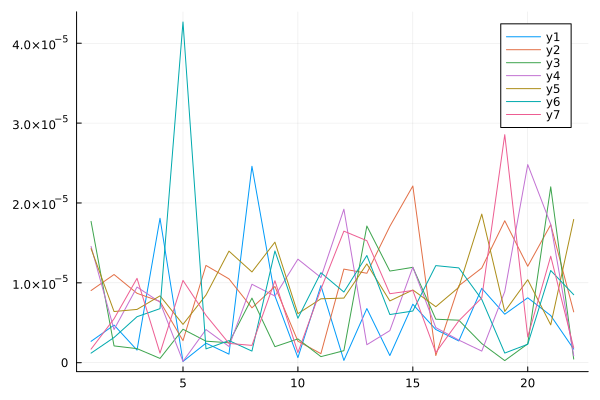

In [12]:
plot(abs.(tsdata-noisy_data)')

In [37]:
### Neural ODE

ann_node = FastChain(FastDense(7, 64, tanh),FastDense(64, 64, tanh), FastDense(64, 64, tanh), FastDense(64, 7))
p = Float64.(initial_params(ann_node))

function dudt_node(u,p,t)
    S,E,I,R,N,D,C = u
    F,β0,α,κ,μ,σ,γ,d,λ = p_
    dS,dE,dI,dR,dD = ann_node([S/N,E,I,R,N,D/N,C],p)

    dN = -μ*N # total population
    dC = σ*E # +cumulative cases

    [dS,dE,dI,dR,dN,dD,dC]
end
prob_node = ODEProblem(dudt_node, u0, tspan, p)
s = concrete_solve(prob_node, Tsit5(), u0, p, saveat = solution.t)

function predict(θ)
    Array(concrete_solve(prob_node, Vern7(), u0, θ, saveat = 1,
                         abstol=1e-6, reltol=1e-6,
                         sensealg = SciMLSensitivity.InterpolatingAdjoint(autojacvec=SciMLSensitivity.ReverseDiffVJP())))
end

# No regularisation right now
function loss(θ)
    pred = predict(θ)
    sum(abs2, (noisy_data[2:4,:] .- pred[2:4,:])), pred # + 1e-5*sum(sum.(abs, params(ann)))
end

loss(p)

const losses = []
callback(θ,l,pred) = begin
    push!(losses, l)
    if length(losses)%50==0
        println(losses[end])
    end
    false
end

┌ Warning: FastChain is being deprecated in favor of Lux.jl. Lux.jl uses functions with explicit parameters f(u,p) like FastChain, but is fully featured and documented machine learning library. See the Lux.jl documentation for more details.
└ @ DiffEqFlux /Users/stevenchiu/.julia/packages/DiffEqFlux/Em1Aj/src/fast_layers.jl:9


callback (generic function with 1 method)

In [39]:
res1_node = DiffEqFlux.sciml_train(loss, p, ADAM(0.01), cb=callback, maxiters = 500);

┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/stevenchiu/.julia/packages/DiffEqFlux/Em1Aj/src/train.jl:6


LoadError: Need an adjoint for constructor SciMLSensitivity.InterpolatingAdjoint{0, true, Val{:central}, SciMLSensitivity.ReverseDiffVJP{false}}. Gradient is of type ChainRulesCore.ZeroTangent

In [38]:
res2_node = DiffEqFlux.sciml_train(loss, res1_node.minimizer, BFGS(initial_stepnorm=0.01), cb=callback, maxiters = 10000);

┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/stevenchiu/.julia/packages/DiffEqFlux/Em1Aj/src/train.jl:6


LoadError: Need an adjoint for constructor SciMLSensitivity.InterpolatingAdjoint{0, true, Val{:central}, SciMLSensitivity.ReverseDiffVJP{false}}. Gradient is of type ChainRulesCore.ZeroTangent

In [32]:
prob_node2 = ODEProblem(dudt_node, u0, tspan, res2_node.minimizer)
s = solve(prob_node2, Tsit5(), saveat = 1)

┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/stevenchiu/.julia/packages/DiffEqFlux/Em1Aj/src/train.jl:6


LoadError: Need an adjoint for constructor SciMLSensitivity.InterpolatingAdjoint{0, true, Val{:central}, SciMLSensitivity.ReverseDiffVJP{false}}. Gradient is of type ChainRulesCore.ZeroTangent

In [ ]:
scatter(solution, vars=[2,3,4], label=["True Exposed" "True Infected" "True Recovered"])
plot!(s, vars=[2,3,4], label=["Estimated Exposed" "Estimated Infected" "Estimated Recovered"])

# Plot the losses
plot(losses, yaxis = :log, xaxis = :log, xlabel = "Iterations", ylabel = "Loss")

# Extrapolate out
prob_node_extrapolate = ODEProblem(dudt_node,u0, tspan2, res2_node.minimizer)
_sol_node = solve(prob_node_extrapolate, Vern7(), abstol=1e-12, reltol=1e-12, saveat = 1)
p_node = scatter(solution_extrapolate, vars=[2,3,4], legend = :topleft, label=["True Exposed" "True Infected" "True Recovered"], title="Neural ODE Extrapolation")
plot!(p_node,_sol_node, lw=5, vars=[2,3,4], label=["Estimated Exposed" "Estimated Infected" "Estimated Recovered"])
plot!(p_node,[20.99,21.01],[0.0,maximum(hcat(Array(solution_extrapolate[2:4,:]),Array(_sol_node[2:4,:])))],lw=5,color=:black,label="Training Data End")

savefig("neuralode_extrapolation.png")
savefig("neuralode_extrapolation.pdf")

In [ ]:
### Universal ODE Part 1

ann = FastChain(FastDense(3, 64, tanh),FastDense(64, 64, tanh), FastDense(64, 1))
p = Float64.(initial_params(ann))

function dudt_(u,p,t)
    S,E,I,R,N,D,C = u
    F, β0,α,κ,μ,σ,γ,d,λ = p_
    z = ann([S/N,I,D/N],p) # Exposure does not depend on exposed, removed, or cumulative!
    dS = -β0*S*F/N - z[1] -μ*S # susceptible
    dE = β0*S*F/N + z[1] -(σ+μ)*E # exposed
    dI = σ*E - (γ+μ)*I # infected
    dR = γ*I - μ*R # removed (recovered + dead)
    dN = -μ*N # total population
    dD = d*γ*I - λ*D # severe, critical cases, and deaths
    dC = σ*E # +cumulative cases

    [dS,dE,dI,dR,dN,dD,dC]
end
prob_nn = ODEProblem(dudt_,u0, tspan, p)
s = concrete_solve(prob_nn, Tsit5(), u0, p, saveat = 1)

plot(solution, vars=[2,3,4])
plot!(s[2:4,:]')

function predict(θ)
    Array(concrete_solve(prob_nn, Vern7(), u0, θ, saveat = solution.t,
                         abstol=1e-6, reltol=1e-6,
                         sensealg = InterpolatingAdjoint(autojacvec=ReverseDiffVJP())))
end

# No regularisation right now
function loss(θ)
    pred = predict(θ)
    sum(abs2, noisy_data[2:4,:] .- pred[2:4,:]), pred # + 1e-5*sum(sum.(abs, params(ann)))
end

loss(p)

const losses = []
callback(θ,l,pred) = begin
    push!(losses, l)
    if length(losses)%50==0
        println(losses[end])
    end
    false
end

res1_uode = DiffEqFlux.sciml_train(loss, p, ADAM(0.01), cb=callback, maxiters = 500)
res2_uode = DiffEqFlux.sciml_train(loss, res1_uode.minimizer, BFGS(initial_stepnorm=0.01), cb=callback, maxiters = 10000)

loss(res2_uode.minimizer)

prob_nn2 = ODEProblem(dudt_,u0, tspan, res2_uode.minimizer)
uode_sol = solve(prob_nn2, Tsit5(), saveat = 1)
plot(solution, vars=[2,3,4])
plot!(uode_sol, vars=[2,3,4])

# Plot the losses
plot(losses, yaxis = :log, xaxis = :log, xlabel = "Iterations", ylabel = "Loss")

# Collect the state trajectory and the derivatives
X = noisy_data
# Ideal derivatives
DX = Array(solution(solution.t, Val{1}))

# Extrapolate out
prob_nn2 = ODEProblem(dudt_,u0, tspan2, res2_uode.minimizer)
_sol_uode = solve(prob_nn2, Vern7(), abstol=1e-12, reltol=1e-12, saveat = 1)
p_uode = scatter(solution_extrapolate, vars=[2,3,4], legend = :topleft, label=["True Exposed" "True Infected" "True Recovered"], title="Universal ODE Extrapolation")
plot!(p_uode,_sol_uode, lw = 5, vars=[2,3,4], label=["Estimated Exposed" "Estimated Infected" "Estimated Recovered"])
plot!(p_uode,[20.99,21.01],[0.0,maximum(hcat(Array(solution_extrapolate[2:4,:]),Array(_sol_uode[2:4,:])))],lw=5,color=:black,label="Training Data End")

savefig("universalode_extrapolation.png")
savefig("universalode_extrapolation.pdf")

### Universal ODE Part 2: SInDy to Equations

# Create a Basis
@variables u[1:3]
# Lots of polynomials
polys = Operation[]
for i ∈ 0:2, j ∈ 0:2, k ∈ 0:2
    push!(polys, u[1]^i * u[2]^j * u[3]^k)
end

# And some other stuff
h = [cos.(u)...; sin.(u)...; unique(polys)...]
basis = Basis(h, u)

X = noisy_data
# Ideal derivatives
DX = Array(solution(solution.t, Val{1}))
S,E,I,R,N,D,C = eachrow(X)
F,β0,α,κ,μ,_,γ,d,λ = p_
L = β.(0:tspan[end],β0,D,N,κ,α).*S.*I./N
L̂ = vec(ann([S./N I D./N]',res2_uode.minimizer))
X̂ = [S./N I D./N]'

scatter(L,title="Estimated vs Expected Exposure Term",label="True Exposure")
plot!(L̂,label="Estimated Exposure")
savefig("estimated_exposure.png")
savefig("estimated_exposure.pdf")

# Create an optimizer for the SINDY problem
opt = SR3()
# Create the thresholds which should be used in the search process
thresholds = exp10.(-6:0.1:1)

# Test on original data and without further knowledge
Ψ_direct = SInDy(X[2:4, :], DX[2:4, :], basis, thresholds, opt = opt, maxiter = 50000) # Fail
println(Ψ_direct.basis)
# Test on ideal derivative data ( not available )
Ψ_ideal = SInDy(X[2:4, 5:end], L[5:end], basis, thresholds, opt = opt, maxiter = 50000) # Succeed
println(Ψ_ideal.basis)
# Test on uode derivative data
Ψ = SInDy(X̂[:, 2:end], L̂[2:end], basis, thresholds,  opt = opt, maxiter = 10000, normalize = true, denoise = true) # Succeed
println(Ψ.basis)

# Build a ODE for the estimated system
function approx(u,p,t)
    S,E,I,R,N,D,C = u
    F, β0,α,κ,μ,σ,γ,d,λ = p_
    z = Ψ([S/N,I,D/N]) # Exposure does not depend on exposed, removed, or cumulative!
    dS = -β0*S*F/N - z[1] -μ*S # susceptible
    dE = β0*S*F/N + z[1] -(σ+μ)*E # exposed
    dI = σ*E - (γ+μ)*I # infected
    dR = γ*I - μ*R # removed (recovered + dead)
    dN = -μ*N # total population
    dD = d*γ*I - λ*D # severe, critical cases, and deaths
    dC = σ*E # +cumulative cases

    [dS,dE,dI,dR,dN,dD,dC]
end

# Create the approximated problem and solution
a_prob = ODEProblem{false}(approx, u0, tspan2, p_)
a_solution = solve(a_prob, Tsit5())

p_uodesindy = scatter(solution_extrapolate, vars=[2,3,4], legend = :topleft, label=["True Exposed" "True Infected" "True Recovered"])
plot!(p_uodesindy,a_solution, lw = 5, vars=[2,3,4], label=["Estimated Exposed" "Estimated Infected" "Estimated Recovered"])
plot!(p_uodesindy,[20.99,21.01],[0.0,maximum(hcat(Array(solution_extrapolate[2:4,:]),Array(_sol_uode[2:4,:])))],lw=5,color=:black,label="Training Data End")

savefig("universalodesindy_extrapolation.png")
savefig("universalodesindy_extrapolation.pdf")